<a href="https://colab.research.google.com/github/hwanys2/ai_practice/blob/main/7_3%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MNIST 데이터셋 불러오기

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
 keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
 train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


#모델 생성하기
모델만드는 함수를 먼저 정의합니다.

In [2]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

input값을 줄경우만 추가로 층을 하나 더 만들고 함수만 바로 실행하면  
flatten, dense, dence 의 층만 구성됨  
실행해보면


In [3]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


위 자료를 fit한 것을 History 변수에 담아 살펴봅니다.

In [4]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)   # verbose=0은 훈련 과정 출력하지 않음

history에는 loss(손실), accuracy(정확도)가 포함되어 있습니다.

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


이를 그림으로 표현해보면

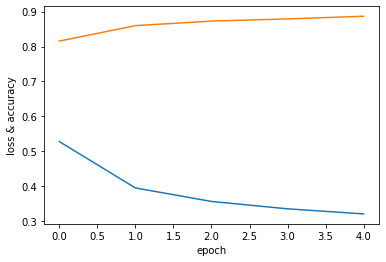

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss & accuracy')
plt.show()

epoch가 늘어날 수록 좋은 성능을 내는 것으로 보이는 횟수를 20으로 늘려 보겠습니다.

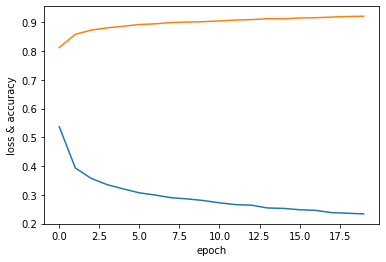

In [10]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss & accuracy')
plt.show()

하지만 이것은 과대적합되는 걸 수 있습니다.  
검증데이터도 함께 진행해 보겠습니다.

In [11]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

그림으로 확인해보겠습니다. 

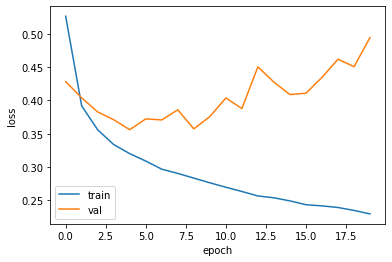

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

이런 과대적합을 막는데 다른 옵티마이저를 선택해 볼 수 있습니다. Adam을 해보겠습니다.

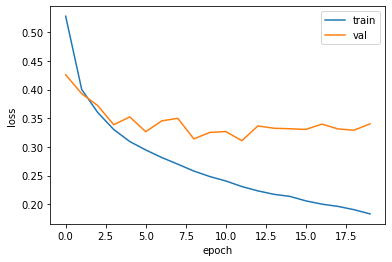

In [13]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 드롭아웃
과대적합을 막기 위해 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 끄는(출력 값을 0 으로 만듦) 방법 입니다.  
keras.layers에 Dropout 클래스가 제공됩니다. 특정 층 뒤에 이를 배치하면 작동합니다.  
함수의 인수로 이 층을 집어넣어 만들어 보겠습니다.

In [14]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


훈련 후 예측시에는 드롭아웃을 적용하지 말아야 하는데 이를 자동으로 케라스에서 진행해 줍니다.  
훈련 손실과 검증 손실의 그래프를 비교하여 그려보겠습니다.

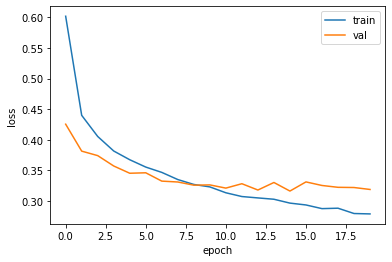

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 확실히 줄었습니다.  
열번째 에포크 정도에서 검증손실이 더이상 감소하지 않고 유지되며 그 이후 과대적합되는듯하니 에포크 횟수가 10이 적당해 보입니다.  
10회 실행하고 이를 저장해보겠습니다.



# 모델 저장과 복원

우선 에포크 횟수를 10으로 다시 실행해보겠습니다.

In [16]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

케라스 모델은 훈련된 모델의 파라미터를 저장하는 간편한 save_weight() 메서드를 제공합니다. 

In [17]:
model.save_weights('model-weights.h5')

또한 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공합니다.

In [18]:
model.save('model-whole.h5')

왼쪽 폴더를 확인하면 파일이 저장되어 있습니다.

먼저 load_weights로 불러와 보겠습니다.  
이 때 불러오는 모델과 정확힌 같은 구조를 가지고 있어야 오류가 나지 않기 때문에  
먼저 모델을 동일하게 만들어 준 후 불러 옵니다.

In [21]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

In [23]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.879


load로 불러와 보겠습니다.  
이경우는 바로 evaluate를 사용할 수 있습니다.

In [24]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3368 - accuracy: 0.8790


[0.33679133653640747, 0.8790000081062317]

# 콜백
콜백은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체입니다.  
keras.callbacks 패키지 아래에 클래스들로 존재합니다.  
ModelCheckpoint 콜백은 기보넉으로 에포크마다 저장합니다.  
save_best_only =True 매개변수를 지정하면 가장 좋은 모델만 저장할 수 있습니다.

In [25]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0,validation_data=(val_scaled, val_target),callbacks=[checkpoint_cb])

이렇게 만들어진 베스트 모델을 읽어서 다시 예측을 수행해보도록 하겠습니다.

In [26]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3154 - accuracy: 0.8857


[0.31543755531311035, 0.8856666684150696]

편하게 최적값을 찾을 수 있게 됩니다.  
하지만 20번의 에포크를 모두 수행하기 보다 과대적합이 시작되기 전에 훈련을 중지시키는 것이 좋을 것 같습니다.  
이를 조기 종료 라고 부릅니다.  
케라스에서는 EarlyStopping 콜백을 제공합니다.  
이 콜백의 patience 매개 변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 저장합니다.  
2로 지정하고 진행해 보겠습니다.

In [27]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,validation_data=(val_scaled, val_target),callbacks=[checkpoint_cb, early_stopping_cb])

언제 멈췄는지 확인해보겠습니다.

In [28]:
print(early_stopping_cb.stopped_epoch)

7


patience를 2로 지정했기 때문에 최상의 모델의 위치를 생각할 수 있습니다.

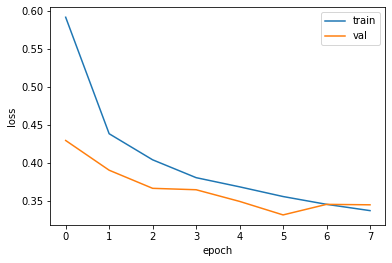

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()